In [1]:
"""\
# Copyright (C) 2025 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 -V || python -V

Python 3.10.12


In [1]:
import os
import sys
import numpy as np
from numpy import linalg as LA

# Plotting
import matplotlib.pyplot as plt
from seaborn import color_palette

# Animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

# --------------------------------------------------------------------------------------

# Swarm Systems Lab PySimUtils
from ssl_pysimutils import createDir, unit_vec, set_paper_parameters

# Python project directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Formations control simulation frame
from afc.sf_affine_complex import sim_frame_affine_complex

# --------------------------------------------------------------------------------------

# Set Matplotlib parameters for happy submission
set_paper_parameters(fontsize=16)

In [11]:
def check_case(sim_fr: sim_frame_affine_complex, params: list[float], debug=False):
    vx, vy, a, omega, hx, hy = params

    kappa = sim_fr.kappa

    # Complex conjugate eigen values
    sigma1 = np.sqrt((hx-omega)*(hy+omega) + 0j)
    sigma2 = - np.sqrt((hx-omega)*(hy+omega) + 0j)
    l1 = kappa*(a + sigma1)
    l2 = kappa*(a + sigma2)

    # Calculate (hx - omega) and (hy + omega)    
    hxw = hx - omega
    hyw = hy + omega

    # Check the cases
    C1a = l1 != 0 and l2 != 0
    C2a = l1 != 0 or l2 != 0
    C3a = (l1 == 0 and l2 == 0) and (hxw == 0 and hyw == 0)
    C3b = (l1 == 0 and l2 == 0) and (vy == 0 and hyw == 0)
    C3c = (l1 == 0 and l2 == 0) and (vx == 0 and hxw == 0)
    C4a = (l1 == 0 and l2 == 0) and (vx != 0 and hyw != 0)
    C4b = (l1 == 0 and l2 == 0) and (vy != 0 and hxw != 0)
    
    if C1a:
        id_case = 0 # C1
    elif C2a:
        id_case = 1 # C2
    elif C3a:
        id_case = 2 # C3
    elif C3b:
        id_case = 3 # C3
    elif C3c:
        id_case = 4 # C3
    elif C4a:
        id_case = 5 # C4
    elif C4b:
        id_case = 6 # C4
    else:
        id_case = None

    # Print the information
    labels = [
        "C1", 
        "C2", 
        "C3 (hxw == 0 and hyw == 0)", 
        "C3 (vy == 0, hyw == 0)", 
        "C3 (vx == 0, hxw == 0)",
        "C4 (vx != 0, hyw != 0)",
        "C4 (vy != 0, hxw != 0)"
    ]

    if debug:  
        print("------------- ->", labels[id_case])
        print("l+ =", l1, " | l- =", l2)
        print("hx - w =", hxw, " | hy + w =", hyw)
        print("vx =", vx, " | vy =", vy)
        print("------------- ")
    else:
        return id_case

In [12]:
def get_pt_parallel(
        sim_fr: sim_frame_affine_complex, params: list[float], alphas: list[float]
    ):
    ## Get data
    vx, vy, a, omega, hx, hy = params

    n = sim_fr.n
    kappa = sim_fr.kappa

    sigma1 = np.sqrt((hx-omega)*(hy+omega) + 0j)
    sigma2 = - np.sqrt((hx-omega)*(hy+omega) + 0j)
    l1 = kappa*(a + sigma1)
    l2 = kappa*(a + sigma2)

    hxw = hx - omega
    hyw = hy + omega

    ps = sim_fr.p_star_c
    ps_x = np.real(ps)
    ps_y = np.imag(ps)

    ## Calculate the eigenvectors (Prop. 2)
    id_case = check_case(sim_fr, params)
    a1, a2, a3 = alphas

    # C1
    if id_case == 0:
        gamma1 = (vx*hxw + vy*sigma1) / (l1/kappa)
        gamma2 = (vx*hxw + vy*sigma2) / (l2/kappa)
        xl1 = gamma1*np.ones(n) + hyw*ps_x + sigma1*ps_y
        xl2 = gamma2*np.ones(n) + hyw*ps_x + sigma2*ps_y
        return lambda t: a1*np.ones(n) + a2*xl1*np.exp(l1*t) + a3*xl2*np.exp(l2*t)
   
    # C2
    elif id_case == 1:
        if l1 != 0:
            l = l1
            gamma1 = (vx*hxw + vy*sigma1) / (l1/kappa)
            xl = gamma1*np.ones(n) + hyw*ps_x + sigma1*ps_y
        else:
            l = l2
            gamma2 = (vx*hxw + vy*sigma2) / (l2/kappa)
            xl = gamma2*np.ones(n) + hyw*ps_x + sigma2*ps_y
        
        x01 = hyw*ps_x - a*ps_y
        x02 = (vx*hyw - vy*a)*np.ones(n)
        return lambda t: a1*x01 + a2*(x02 + x01*t) + a3*xl*np.exp(l*t)
        
    # C3
    elif id_case in [2,3,4]:
        if id_case == 2: # "C3 (hxw == 0 and hyw == 0)"
            y01 = vy*ps_x - vy*ps_y
            y02 = (vx + 1j*vy) * np.ones(n)
        elif id_case == 3: # "C3 (vy == 0, hyw == 0)"
            y01 = hx*np.ones(n) - vx*ps_y
            y02 = vx*np.ones(n) + hx*ps_y
        elif id_case == 4: # "C3 (vx == 0, hxw == 0)"
            y01 = 1j*(hy*np.ones(n) - vy*ps_x)
            y02 = 1j*(vy*np.ones(n) + hy*ps_x)
        return lambda t: a1*y01 * a2*y02 + a3*(ps + y02*t)

    # C4
    elif id_case in [5,6]:
        if id_case == 5: # "C4 (vx != 0, hyw != 0)"
            z01 = 1j*vx*hy*np.ones(n)
            z02 = vx*np.ones(n) + 1j*hy*ps_x
        elif id_case == 6: # "C4 (vy != 0, hxw != 0)"
            z01 = vy*hx*np.ones(n)
            z02 = 1j*vy*np.ones(n) + hx*ps_y
        return lambda t: a1*z01 + a2*(z02 + z01*t) + a3*(ps + z02*t + z01*t**2)

    else:
        return None

## Simulations

In [54]:
## Parameters #####

# Reference shape
p_star = np.array([[-1,-1], [-1,1], [1,1], [1,-1]]) # square
n = p_star.shape[0]

## Generate the simulation frames #####
tf = 2
h = 10

args = {
    "n"     : n, 
    "Z"     : ((1,2), (1,3), (2,3), (2,4), (3,4), (4,1)), 
    "p_star": p_star,
    "p0"    : [[-10,-3], [-5,-5], [0,4], [0,-5]],
    "tf"    : tf, 
    "h"     : h,
    "kappa" : 1, 
    "K"     : np.eye(n)
}

sim_fr = sim_frame_affine_complex(**args)

Failed to dualize the problem: 'float' object is not iterable


In [55]:
## Design the parameters of a body-fixed desired velocity in S #####

# Parameters examples ----------------------------------
# C1
params_deg_c1 = [1, 0, 0, 2, 1, 0]

# C2
params_deg_c2 = [0, 0, 1, 1, 2, 0]

# C3
params_deg_c3a = [1, 1, 0, 0, 0, 0]
params_deg_c3b = [1, 0, 0, 0, 4, 0]
params_deg_c3c = [0, 1, 0, 0, 0, 4]

# C4
params_deg_c4a = [1, 0, 0, 0, 0, 4]
params_deg_c4b = [0, 1, 0, 0, 4, 0]
# ------------------------------------------------------

params = [1, 0, 0, 0, 0, 0]
check_case(sim_fr, params, debug=True)

------------- -> C3 (hxw == 0 and hyw == 0)
l+ = 0j  | l- = 0j
hx - w = 0  | hy + w = 0
vx = 1  | vy = 0
------------- 


hl = 0


100%|██████████| 2000/2000 [00:00<00:00, 46401.02it/s]


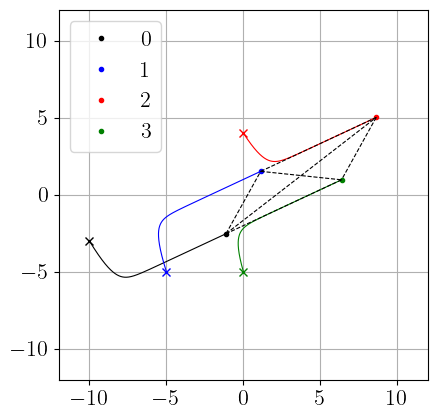

In [57]:
## Design M #####
# Set the parameters
vx, vy, a, omega, hx, hy = params

# Design the weights that gerenates the body-fixed desired velocity v_f^*
mu_matrix_x = np.array([[0,0,0,-1], [0,0,-1,0], [0,1,0,0], [1,0,0,0]])/2
mu_matrix_y = np.array([[0,-1,0,0], [1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

mu_matrix_a = np.array([[0,1,0,1], [1,0,1,0], [0,1,0,1], [1,0,1,0]])/2
mu_matrix_w = np.array([[0,1,0,-1], [-1,0,1,0], [0,-1,0,1], [1,0,-1,0]])/2
mu_matrix_hx = np.array([[0,0,0,1], [0,0,-1,0], [0,1,0,0], [-1,0,0,0]])/2
mu_matrix_hy = np.array([[0,1,0,0], [-1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

# Pass the weights to the simulation frame, it will compute M and L_mod
sim_fr.set_manual_mu(
    vx*mu_matrix_x + vy*mu_matrix_y + 
    a*mu_matrix_a + omega*mu_matrix_w + 
    hx*mu_matrix_hx + hy*mu_matrix_hy
)

## Calculate the lower bound of h (h_l) #####
hl = 0
print("hl =", hl)

## Launch the simulation and plot #####
sim_fr.numerical_simulation()
sim_fr.plot(lim=12)

# Simulation (4 cases)

In [64]:
## Parameters #####

# Reference shape
p_star = np.array([[-1,-1], [-1,1], [1,1], [1,-1]]) # square
n = p_star.shape[0]

# Initial condition
ps = p_star[:, 0] + p_star[:, 1] * 1j
lambda d: (d[0] + 1j*d[1])*np.ones(n) + (d[2] + 1j*d[3])*np.real(ps) + (d[4] + 1j*d[5])*np.imag(ps)

## Generate the simulation frames #####
tf = 1
h = 100

args = {
    "n"     : n, 
    "Z"     : ((1,2), (1,3), (2,3), (2,4), (3,4), (4,1)), 
    "p_star": p_star,
    "p0"    : p_star,
    "tf"    : tf, 
    "h"     : h,
    "kappa" : 1, 
    "K"     : np.eye(n), 
    "debug" : False
}

sim_fr = sim_frame_affine_complex(**args)

Failed to dualize the problem: 'float' object is not iterable


In [65]:
## Design the parameters of a body-fixed desired velocity in S #####

# Parameters examples ----------------------------------
# C1
params_deg_c1 = [1, 0, 0, 2, 1, 0]

# C2
params_deg_c2 = [0, 0, 1, 1, 2, 0]

# C3
params_deg_c3a = [1, 1, 0, 0, 0, 0]
params_deg_c3b = [1, 0, 0, 0, 4, 0]
params_deg_c3c = [0, 1, 0, 0, 0, 4]

# C4
params_deg_c4a = [1, 0, 0, 0, 0, 4]
params_deg_c4b = [0, 1, 0, 0, 4, 0]
# ------------------------------------------------------

params = params_deg_c3a
check_case(sim_fr, params, debug=True)

------------- -> C3 (hxw == 0 and hyw == 0)
l+ = 0j  | l- = 0j
hx - w = 0  | hy + w = 0
vx = 1  | vy = 1
------------- 


In [66]:
## Design M #####
# Set the parameters
vx, vy, a, omega, hx, hy = params

# Design the weights that gerenates the body-fixed desired velocity v_f^*
mu_matrix_x = np.array([[0,0,0,-1], [0,0,-1,0], [0,1,0,0], [1,0,0,0]])/2
mu_matrix_y = np.array([[0,-1,0,0], [1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

mu_matrix_a = np.array([[0,1,0,1], [1,0,1,0], [0,1,0,1], [1,0,1,0]])/2
mu_matrix_w = np.array([[0,1,0,-1], [-1,0,1,0], [0,-1,0,1], [1,0,-1,0]])/2
mu_matrix_hx = np.array([[0,0,0,1], [0,0,-1,0], [0,1,0,0], [-1,0,0,0]])/2
mu_matrix_hy = np.array([[0,1,0,0], [-1,0,0,0], [0,0,0,1], [0,0,-1,0]])/2

# Pass the weights to the simulation frame, it will compute M and L_mod
sim_fr.set_manual_mu(
    vx*mu_matrix_x + vy*mu_matrix_y + 
    a*mu_matrix_a + omega*mu_matrix_w + 
    hx*mu_matrix_hx + hy*mu_matrix_hy
)

## Calculate the lower bound of h (h_l) #####
hl = 0
print("hl =", hl)

## Launch the simulation and plot #####
sim_fr.numerical_simulation()

hl = 0


100%|██████████| 1000/1000 [00:00<00:00, 24721.97it/s]


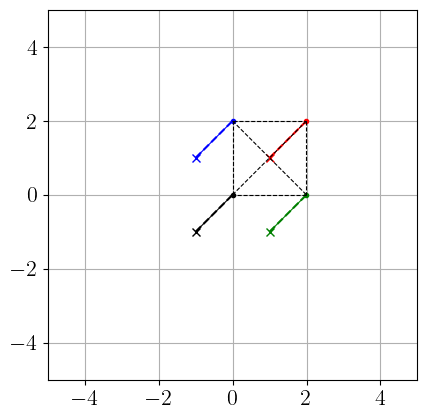

In [67]:
pt_parallel = get_pt_parallel(sim_fr, params, [0,1,1])

# Evaluate
t_list = np.linspace(0,sim_fr.tf,100)
p_eval = []

for t in t_list:
    p_eval.append(pt_parallel(t))
p_eval = np.array(p_eval)

# Plot analytical solution
fig = plt.figure()
ax = fig.subplots()

lim = 5
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])

ax.grid(True)
ax.set_aspect("equal")

colors = ["k", "b", "r", "g"]
for i in range(4):
    ax.plot(np.real(p_eval)[:,i], np.imag(p_eval)[:,i], c=colors[i], ls="--")

# Plot the simulation
sim_fr.plot(ax)

plt.show()
